### РОССИЙСКИЙ УНИВЕРСИТЕТ ДРУЖБЫ НАРОДОВ

#### Факультет физико-математических и естественных наук  
#### Кафедра информационных технологий

### ОТЧЕТ ПО ЛАБОРАТОРНОЙ РАБОТЕ № 7


#### Дисциплина: Методы машинного обучения

##### Студент: Мухамедияр Адиль
##### Группа: НКНбд-01-20

## Москва 2023
***

# Постановка задачи:

В соответствии с индивидуальным заданием, указанным в записной книжке команды, выполните следующие работы:  

1. Загрузите заданный в индивидуальном задании набор данных с изображениями из Tensorflow Datasets с разбиением на обучающую и тестовую выборки. Оставьте в обучающей и тестовой выборках диапазон классов, указанных в индивидуальном задании. Если изображения цветные (с тремя каналами), то перекодируйте их в одноцветные (оттенки серого).

2. Создайте и обучите на обучающей выборке автокодировщик архитектуры, указанной в индивидуальном задании. Визуализируйте несколько исходных и восстановленных автокодировщиком изображений.  

3. Оцените качество модели автокодировщика на тестовой выборке по показателю, указанному в индивидуальном задании. 

4. Оставьте в наборах изображения первых двух классов диапазона, указанного в индивидуальном задании первыми. Визуализируйте набор данных на плоскости, соответствующей двум первым латентным признакам, отображая точки различных классов разными цветами. Подпишите оси и рисунок, создайте легенду для классов набора данных. 

5. Выполните бинарную классификацию изображений по латентным (скрытым) признакам и всем признакам при помощи классификатора метода ближайших соседей (kNN). Оцените долю верных ответов (accuracy) для двух построенных классификаторов 

6. Визуализируйте ROC-кривые для построенных классификаторов на одном рисунке (с легендой) (Указание: используйте метод predict_proba() класса KNeighborsClassifier). 

7. Визуализируйте границы принятия решений классификатора kNN для латентных признаков на плоскости, соответствующей двум первым латентным признакам (для прочих латентных признаков задайте средние/медианные значения).  

8. Определите на первоначальной тестовой выборке изображение, имеющее наибольшую ошибку реконструкции. Выведите для этого изображения первоначальное и реконструированное изображения. 

# Вариант №21



### Дополнение к основной задаче:

1. Набор данных: coil100 

2. Диапазон классов: 21–25 

3. Архитектура нейросети: CNN 

4. Показатель качества: cреднее квадратичное логарифмическое отклонение (MSLE) для ошибки реконструкции 

## Решение:

In [1]:
import numpy as np
import tensorflow.keras as keras
import tensorflow_datasets as tfds
import pandas as pd
import time
import sys
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import tensorflow as tf


### Пункт 1

Загрузим из __Tensorflow datasets__ набор данных `coil100`:

In [2]:
# Загружаем наш датасет:
dataset = tfds.load("coil100", split='train', as_supervised=True)
dataset = dataset.batch(len(dataset)) # Пакетное преобразование набора данных, чтобы получить все данные в одном пакете

# Преобразовываем набор данных в массивы numpy
(X_train, y_train) = next(iter(dataset))
X_train = np.array(X_train)
y_train = np.array(y_train)

print(f"Train dataset shape: {X_train.shape}")
print(f"Train labels shape: {y_train.shape}")


Train dataset shape: (7200, 128, 128, 3)
Train labels shape: (7200,)


In [3]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2)
print(f"Train dataset shape: {X_train.shape}")
print(f"Test dataset shape: {X_test.shape}")

Train dataset shape: (5760, 128, 128, 3)
Test dataset shape: (1440, 128, 128, 3)


In [4]:
# Диапазон классов: 21-25
filtered_indices_train = np.where(np.logical_and(y_train >= 21, y_train <= 25))
filtered_indices_test = np.where(np.logical_and(y_test >= 21, y_test <= 25))
X_train = X_train[filtered_indices_train]
y_train = y_train[filtered_indices_train]
X_test = X_test[filtered_indices_test]
y_test = y_test[filtered_indices_test]

# Преобразуем красочные изображения в оттенки серого:
X_train = np.asarray([rgb2gray(image) for image in X_train])
X_test = np.asarray([rgb2gray(image) for image in X_test])

# Нормализуем изображения в оттенках серого:
X_train = X_train / 255.0
X_test = X_test / 255.0

print("Размер: ", X_train[0].shape)

Размер:  (128, 128)


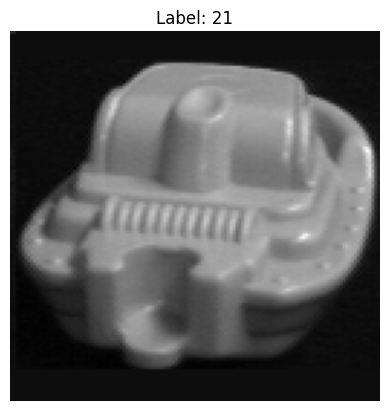

In [5]:
# Распечатаем один пример изображения в оттенках серого:
example_index = 7
example_image = X_train[example_index]
example_label = y_train[example_index]

plt.imshow(example_image, cmap='gray')
plt.title(f"Label: {example_label}")
plt.axis('off')
plt.show()

### Пункт 2

In [6]:
def image_show(orig_imgs, dec_imgs, fname=None):
    n = 5  # кол-во изображений
    fig = plt.figure(figsize=(24, 5))
    for i in range(n):
        # исходные изображения
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(orig_imgs[i].reshape(32, 32))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # реконструированные изображения
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(dec_imgs[i].reshape(32, 32))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.tight_layout()
    plt.show()

    if fname:
        fig.savefig(fname)

X_train = X_train.reshape(
    (len(X_train), np.prod(X_train.shape[1:])))
X_test  = X_test.reshape(
    (len(X_test), np.prod(X_test.shape[1:])))
X_train.shape, X_test.shape

((386, 16384), (114, 16384))

In [7]:
from tensorflow.keras.layers import Conv2D,MaxPooling2D,UpSampling2D

def autoencoder_model():
  input_img = tf.keras.Input(shape=(128, 128, 1))
  x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
  x = MaxPooling2D((2, 2), padding='same')(x)
  x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
  encoded = MaxPooling2D((2, 2), padding='same')(x)

  x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
  x = UpSampling2D((2, 2))(x)
  x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
  x = UpSampling2D((2, 2))(x)
  decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
  autoencoder = Model(input_img, decoded)
  return autoencoder

autoencoder = autoencoder_model()
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [8]:
X_train.shape, X_test.shape

((386, 16384), (114, 16384))

In [9]:
X_trainCNN = X_train.reshape(
(len(X_train), 128, 128, 1))
X_testCNN = X_test.reshape(
(len(X_test), 128, 128, 1))

X_trainCNN.shape, X_testCNN.shape

((386, 128, 128, 1), (114, 128, 128, 1))

In [10]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
history = autoencoder.fit(X_train, X_train,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(X_test, X_test),
                verbose = 1);

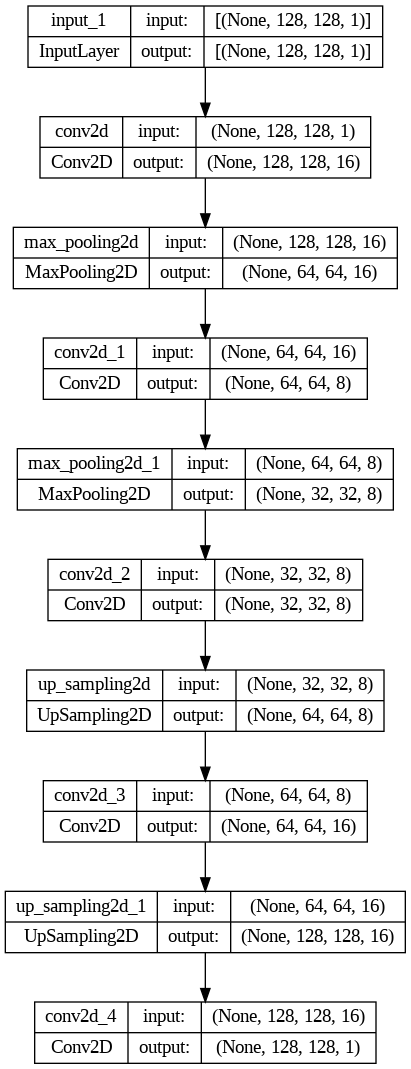

In [12]:
keras.utils.plot_model(autoencoder, show_shapes=True)

In [13]:
decoded_imgs = autoencoder.predict(X_testCNN)


4/4 [==============================] - 1s 196ms/step


In [ ]:
image_show(X_test, decoded_imgs)

### Пункт 3

In [14]:
reconstructed_images = autoencoder.predict(X_testCNN)

4/4 [==============================] - 1s 198ms/step


In [15]:
mse = tf.keras.losses.mean_squared_error(X_testCNN, reconstructed_images)
mse_value = tf.reduce_mean(mse)
print("MSE:", mse_value.numpy())

MSE: 0.24895918
